This notebook demonstrates how to use BART for parallel MRI reconstruction. 

To run locally, we'll need:

1. a `bart` installation (v0.7.00 or later) 

2. a `python3` programming environment

3. to expose our `python3` instance to `bart`'s python bindings in `/path/to/bart/python`. 

We can check our environment by importing the necessary libraries:

In [50]:
import bart
import cfl
import matplotlib.pyplot as plt
import numpy as np

The `bart` python module contains an eponymous function that enables calling `bart` functions from a python instance. The syntax is `output = bart.bart(nargout, command, arg0, arg1, ...)`.

As an example, let's simulate some multicoil k-space data with the `phantom` command:

In [51]:
nkyz = 256
nc = 8
ksp_ful_nonoise = bart.bart(1, 'phantom -x {} -k -s {}'.format(nkyz, nc))
ksp_ful_nonoise.shape

(256, 256, 1, 8)

Let's also add noise of a given variance level, fixing the random seed for reproducibility:

In [52]:
noi_var = 1000
seed = 20210714
ksp_ful = bart.bart(1, 'noise -n {} -s {}'.format(noi_var, seed), ksp_ful_nonoise)
ksp_ful.shape

(256, 256, 1, 8)

Multicoil acquisitions enable reasonable reconstruction from undersampled data, so let's mask out some entries of our fully-sampled data `ksp_ful` before proceeding. 

We can construct a binary Poisson-disk sampling mask using the `poisson` command. The options `-y` and `-z` enable setting a different acceleration factor along each axis. The option `-C` sets the width and height of a fully-sampled central region. The option `-V` controls how uniformly samples are distributed in the higher-frequency regions of k-space.

In [73]:
acc_y = 3
acc_z = 1.5
calib_dim = 16
vdf = 20
mask_args = (nkyz, nkyz, acc_y, acc_z, calib_dim, vdf)
mask = bart.bart(1, 'poisson -Y {} -Z {} -y {} -z {} -C {} -V {} -e'.format(*mask_args))
mask.shape

(1, 256, 256)

Note that the `mask` shape reflects 3D Poisson-disk sampling, as is used in practice. Let's reshape once to apply the mask, then again for display purposes:

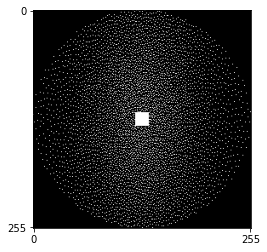

In [99]:
def disp(im, figsize=(4,4)): # to avoid code repetition
    _, ax = plt.subplots(figsize=figsize)
    ax.set_xticks([0, nkyz-1])
    ax.set_yticks([0, nkyz-1])
    ax.imshow(abs(im), cmap='gray')
    
mask.shape = (nkyz, nkyz, 1, 1) # for array broadcasting
ksp = ksp_ful * mask

mask.shape = (nkyz, nkyz)
disp(mask)

We now have Poisson-disk undersampled multicoil k-space data and will seek to reconstruct this data in a few different ways. 

Let's first try a simple FFT-based reconstruction. The idea is to apply an FFT along the $k_y, k_z$ directions to produce an image for each coil, and then to combine these coil images pixel-by-pixel by calculating the root sum-of-squares across coils. We can implement these steps via the `fft` and `rss` commands, respectively. 

Both `fft` and `rss` use bitmasks to specify the dimensions along which to operate. BART facilitates bitmask calculation using the `bitmask` command. For example, we need to apply `fft` along the 0th and 1st dimensions of `ksp`. The associated bitmask (in decimal representation) can be calculated as:

In [106]:
!bart bitmask 0 1

WARN: BART version is not reproducible.
3


We pass this decimal bitmask to the `fft` command to produce coil images:

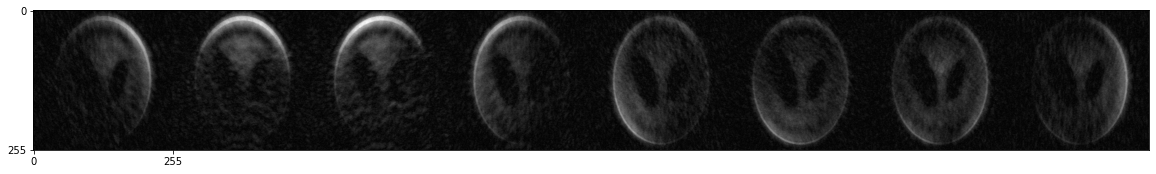

In [107]:
im_coil = bart.bart(1, 'fft -u -i 3', ksp)
disp(np.concatenate([im_coil[:,:,0,i] for i in range(nc)], 1), figsize=(20,10))

As a second example, we next need to apply `rss` along the 3rd dimension of `im_coil`. We can calculate and then pass the decimal bitmask to `rss` to obtain the FFT-based reconstruction:

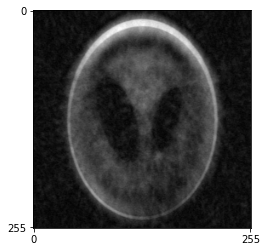

In [108]:
im_rss = bart.bart(1, 'rss $(bart bitmask 3)', im_coil)
disp(im_rss)

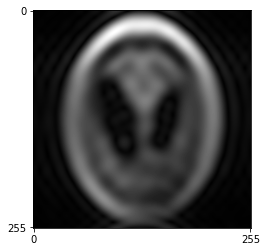

In [56]:
# simulate low-resolution data for coil sensitivity estimation
# todo: consider mentioning compatibility with autocalib 
ksp_smap_nonoise = bart.bart(1, 'phantom -x {} -k -s {}'.format(calib_dim, nc))
seed_smap = np.random.randint(0, 2**63-1)
pad = int((nkyz-calib_dim)/2)
ksp_smap = np.pad(bart.bart(1, 'noise -n {} -s {}'.format(noi_var, seed_smap),
                            ksp_smap_nonoise), ((pad,), (pad,), (0,), (0,)))
# todo: use `bart resize -c 0 256 1 256 input output`

im_coil_smap = bart.bart(1, 'fft -i -u $(bart bitmask 0 1 2)', ksp_smap)
im_rss_smap = bart.bart(1, 'rss $(bart bitmask 3)', im_coil_smap)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(im_rss_smap), cmap='gray')

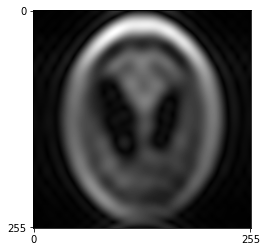

In [57]:
# compress coil sensitivity data to ncc virtual coils
# save coil compression matrix to be used for `ksp` also
# todo: mention other coil compression options
cc_mtx = bart.bart(1, 'cc -M -S', ksp_smap)
ncc = 5
ksp_smap_cc = bart.bart(1, 'ccapply -p {} -S'.format(ncc), ksp_smap, cc_mtx)

im_coil_smap = bart.bart(1, 'fft -i -u $(bart bitmask 0 1 2)', ksp_smap_cc)
im_rss_smap = bart.bart(1, 'rss $(bart bitmask 3)', im_coil_smap)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(im_rss_smap), cmap='gray')

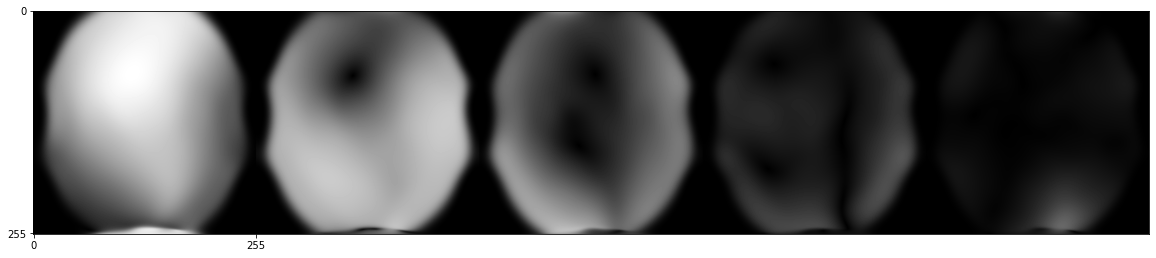

In [58]:
# estimate coil sensitivities via ESPIRiT
smap = bart.bart(1, 'ecalib -m 1 -S', ksp_smap_cc) # -m 1 skips (eig?) maps on 4th dim
_, ax = plt.subplots(figsize=(20,10))
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(np.concatenate([abs(smap[:,:,0,i]) for i in range(ncc)], 1), cmap='gray')

In [59]:
# compress `ksp` using the same compression matrix
ksp_cc = bart.bart(1, 'ccapply -p {} -S'.format(ncc), ksp, cc_mtx)

ESPIRiT is described in this [paper](https://pubmed.ncbi.nlm.nih.gov/23649942): 

Uecker et al. ESPIRiT -- an eigenvalue approach to autocalibrating parallel MRI: where SENSE meets GRAPPA. Magnetic Resonance in Medicine, 71:990-1001 (2014).

In [60]:
# reconstruct using espirit with quadratic regularization
quad_reg = 0.1
im_quad = bart.bart(1, 'pics -R Q:{} -S -d5'.format(quad_reg), ksp_cc, smap)

In [61]:
# reconstruct using espirit with l1-wavelet regularization
wav_reg = 0.2
im_wav = bart.bart(1, 'pics -R W:7:0:{} -S -d5'.format(wav_reg), ksp_cc, smap)

In [62]:
# reconstruct using espirit with l1 total-variation regularization
tv_reg = 0.1
im_tv = bart.bart(1, 'pics -R T:7:0:{} -S -d5'.format(tv_reg), ksp_cc, smap)

In [63]:
To evaluate our reconstructions later, it will be use

SyntaxError: invalid syntax (<ipython-input-63-482aa8a5a6fa>, line 1)

In [ ]:
# root-sum-of-squares reconstruction from fully-sampled data
im_ful_coil = bart.bart(1, 'fft -i -u $(bart bitmask 0 1)', ksp_ful)
im_ful_rss = bart.bart(1, 'rss $(bart bitmask 3)', im_ful_coil)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(im_ful_rss), cmap='gray')

In [ ]:
# compare the results
_, ax = plt.subplots(figsize=(20,10))
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(np.concatenate([im_ful_rss, im_rss, im_quad, im_wav, im_tv], 1)), cmap='gray')